The goal of this notebook is to verify our implementation of the DMDc algorithm

In [147]:
# Imports
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
from scipy.signal import cont2discrete
import pyvista as pv
import h5py
import mat73
import dask.array as da
from dask.distributed import Client, LocalCluster
import opinf
config = dotenv_values(".env")
from util import *
from scipy import signal

In [148]:
# # Setup Dask client
# # cluster = LocalCluster() # Launches a scheduler and workers locally
# # client = Client(cluster) # Connect to distributed cluster and override default
# client = Client('tcp://127.0.0.1:8786')
# client.cluster

In [149]:
# Hyperparameters for simulation
n = 5000 # dimension of full order state
l = 6 # dimension of input vector
m = 40 # dimension of output vector

n_timesteps = 250 # number of timesteps to simulate
dt = 0.01 # timestep size




In [163]:
# Make random linear system matrices with some sparsity where entries are drawn from normal distribution
A = np.random.rand(n,n)
A[np.abs(A<0.4)] = 0
A = A - np.diag(np.sum(A, axis=0))
B = np.random.rand(n, l)
C = np.random.rand(m, n)
D = np.zeros((m, l))



In [164]:
# Make discrete time linear system
dMats = signal.cont2discrete((A, B, C, D), dt=dt)
sys = signal.dlti(dMats[0], dMats[1], dMats[2], dMats[3], dt=dt)
A_d = dMats[0]
B_d = dMats[1]
C_d = dMats[2]
D_d = dMats[3]

In [176]:
# Set initial condition and input
x0 = np.zeros((n, 1))
u = (np.random.rand(l, n_timesteps)-0.5)*0.0001

# Set amount of gaussian noise to add to input
eps_input = 0.000001
eps_output = 0.00001


In [177]:
# Simulate discrete time linear system
# Initialize array to hold state data and output data
X_fom = np.zeros((n, n_timesteps))
X_fom[:, [0]] = x0
Y_fom = np.zeros((m, n_timesteps))
Y_fom[:, [0]] = np.dot(C, x0)

In [178]:
# Simulate system
for i in range(1, n_timesteps):
    X_fom[:, i] = np.dot(A_d, X_fom[:, i-1]) + np.dot(B_d, u[:,i-1]) + np.random.normal(0, eps_input, (n, 1))[:,0]
    Y_fom[:, i] = np.dot(C_d, X_fom[:, i]) + np.dot(D_d, u[:,i-1]) + np.random.normal(0, eps_output, (m, 1))[:,0]

In [179]:
# Make DMDc Data matrices
X_train = da.from_array(X_fom[:, :-1], chunks=(n, 100))
Xprime_train = da.from_array(X_fom[:, 1:], chunks=(n, 100))
Upsilon_train = da.from_array(u[:, :-1], chunks=(l, 100))
Y_train = da.from_array(Y_fom[:, :-1], chunks=(m, 100))

In [180]:
# Compute DMDc ROM
p_dmd = n/2# dimension of reduced input space
n_ROM = 20 # dimension of reduced order state
# Form snapshot matrices for DMDc
Omega = da.concatenate([X_train,Upsilon_train],axis=0)
print("got here 4")
# Decompose snapshot matrix using truncated SVD
r_dmd = n_ROM
print("got here 5")
U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd_compressed(Omega, p_dmd)
# Vh_tilde = da.conj(da.transpose(V_tilde))
Sigma_tilde = da.diag(Sigma_tilde)
U_hat, Sigma_hat, V_hat = da.linalg.svd_compressed(Xprime_train, r_dmd)
Sigma_hat = da.diag(Sigma_hat)
print("got here 6")
# Compute system state evolution matrices
U_tilde_1 = U_tilde[0:n,:]
U_tilde_2 = U_tilde[n:,:]
A_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)@U_hat
B_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)

print("got here 7")

# Solve for system output matrix from full order system
ys = Y_train[:,0:250]

# compute approximate pseudoinverse of data matrix using SVD
# X_train = X_train.rechunk((2000,X_train.shape[1])) # Rechunk along one dimension
U_X_train, S_X_train, Vh_X_train = da.linalg.svd(X_train[:,0:250])
X_PI = da.matmul(da.transpose(Vh_X_train),da.matmul(da.diag(da.reciprocal(S_X_train)),da.transpose(U_X_train)))

print("got here 8")

# # X_PI = np.linalg.pinv(X_train[:,0:10])
C_dmdc = ys@X_PI
C_dmdc = C_dmdc@U_hat
print("got here 9")
# Execute computations for dmdc system matrices
print("Computing DMDc system matrices for n_ROM = ", n_ROM)
A_dmdc, B_dmdc, C_dmdc,U_hat = da.compute(A_dmdc, B_dmdc, C_dmdc,U_hat)
# A_dmdc, B_dmdc = da.compute(A_dmdc, B_dmdc)
# A_dmdc = A_dmdc.compute()
print("got here 10")
# B_dmdc = B_dmdc.compute()
# print("got here 11")
# C_dmdc = C_dmdc.compute()
# print("got here 12")
# U_hat = U_hat.compute()
# print("got here 13")
basis_dmdc = U_hat[:,0:n_ROM]



got here 4
got here 5
got here 6
got here 7
got here 8
got here 9
Computing DMDc system matrices for n_ROM =  20
got here 10


In [181]:
# Solve for C by projecting outputs onto reduced order state space


In [182]:
# Simulate DMDc ROM with same inputs
# Initialize array to hold state data and output data
X_dmdc = np.zeros((n_ROM, n_timesteps))
X_dmdc[:, [0]] = np.zeros((n_ROM, 1))
Y_dmdc = np.zeros((m, n_timesteps))
Y_dmdc[:, [0]] = np.zeros((m, 1))
# Simulate system
for i in range(1, n_timesteps):
    X_dmdc[:, i] = np.dot(A_dmdc, X_dmdc[:, i-1]) + np.dot(B_dmdc, u[:, i-1])
    Y_dmdc[:, i] = np.dot(C_dmdc, X_dmdc[:, i])

In [183]:
# Project reduced order state back to full order state
X_dmdc_full = np.dot(basis_dmdc, X_dmdc)

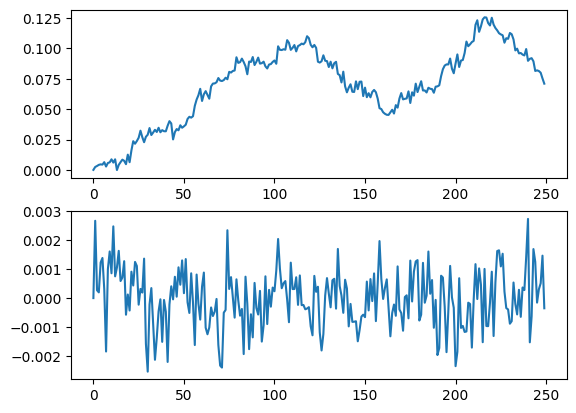

In [184]:
# Plot first dmdc output vs first fom output on separate plots
fig, ax = plt.subplots(2, 1)
index = 3
ax[0].plot(Y_fom[index, :1000])
ax[1].plot(Y_dmdc[index, :1000])
plt.show()

# ax.plot(Y_fom[0, :1000], label="FOM")
# ax.plot(Y_dmdc[2, :1000], label="DMDc")
# ax.legend()
plt.show()


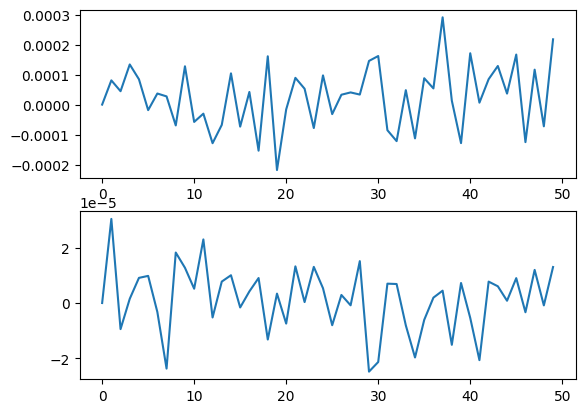

In [185]:
# Plot first dmdc output vs first fom output on separate plots
fig, ax = plt.subplots(2, 1)
index = 1
ax[0].plot(X_fom[index, :50])
ax[1].plot(X_dmdc_full[index, :50])
plt.show()

# ax.plot(Y_fom[0, :1000], label="FOM")
# ax.plot(Y_dmdc[2, :1000], label="DMDc")
# ax.legend()
plt.show()


In [186]:
# Compute relative errors between FOM and DMDc states and outputs
X_err = np.linalg.norm(X_fom - X_dmdc_full)/np.linalg.norm(X_fom)
Y_err = np.linalg.norm(Y_fom - Y_dmdc)/np.linalg.norm(Y_fom)
print("X error: ", X_err)
print("Y error: ", Y_err)

X error:  1.0033866928772497
Y error:  1.0009517334754856
